In [1]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap

In [3]:
# 2. Load Dataset
df = pd.read_csv("bank-full.csv", sep=";")
print("Shape:", df.shape)
print(df.head())

Shape: (45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [4]:
# 3. Encode Categorical Features
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

In [5]:
# 4. Train/Test Split
X = df.drop("y", axis=1)
y = df["y"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
log_reg = LogisticRegression(max_iter=5000, solver='lbfgs')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)

In [ ]:
# 5. Train Models
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)


log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

In [7]:
# 6. Predictions
y_pred_log = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [8]:
# 7. Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"===== {model_name} =====")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))

===== Logistic Regression =====


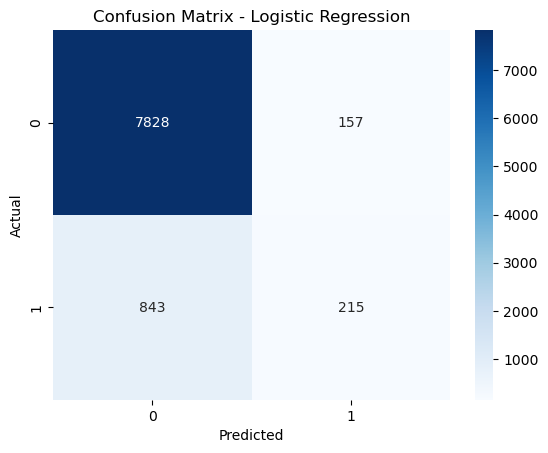

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.58      0.20      0.30      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.59      0.62      9043
weighted avg       0.86      0.89      0.87      9043

F1-Score: 0.3006993006993007
===== Random Forest =====


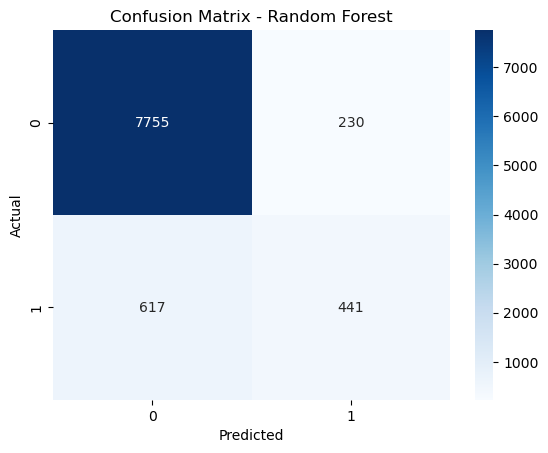

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7985
           1       0.66      0.42      0.51      1058

    accuracy                           0.91      9043
   macro avg       0.79      0.69      0.73      9043
weighted avg       0.89      0.91      0.90      9043

F1-Score: 0.5101214574898786


In [9]:
# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_log, "Logistic Regression")


# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

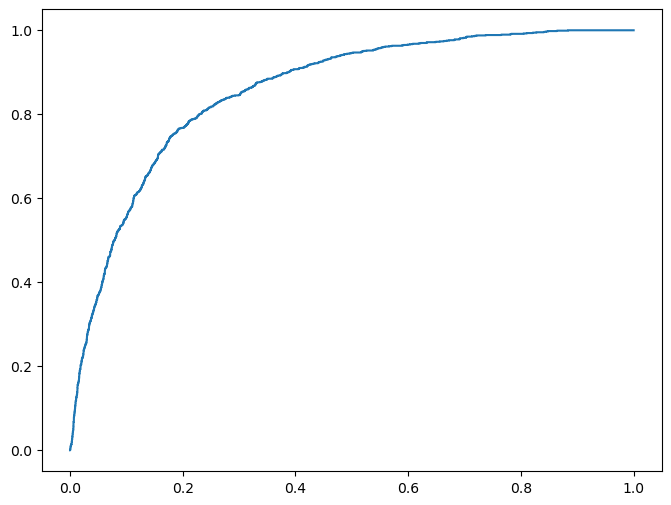

In [10]:
# 8. ROC Curve
plt.figure(figsize=(8,6))


# Logistic Regression
y_prob_log = log_reg.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.2f})")

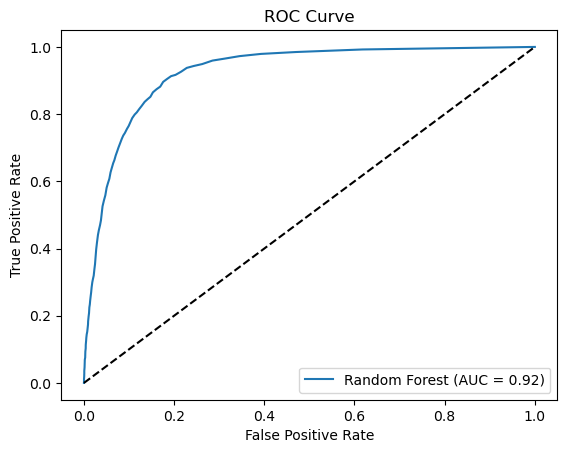

In [11]:
# Random Forest
y_prob_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")


plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
# 9. SHAP Explainability
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [ ]:
# Summary plot
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [ ]:
# Explain 5 predictions
for i in range(5):
print(f"\nPrediction explanation for sample {i}:")
shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_test.iloc[i], matplotlib=True)